# DMD, eDMD, HankelDMD (Analysis not yet ready)

### importing libraries

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

### Setting parameters

In [2]:
DMD_type = 'eDMD'  #DMD or eDMD or HankelDMD
step = 'N_step'  #Calculates a the system dynamics matrix for one step but can be one_step or N_step prediction
poly_type = 'Hermite'  #Monomials, Hermite, Legendre. ###Note, Legendre not used as indicator functions oe=wing to scalability
poly_order = 3

system_name = 'Repressilator' #Glycoscillator or Repressilator
num_test = 1  #num of test states in Simulation_Init_conditions.py. More test or training can be added there

data_trained = 0.14   #ratio of post-transient data shown FROM EACH TRAJECTORY
transient_skip = 100 # Time stamp upto which data is not considered for training. Minimum dt for indexing purposes
T = 200   #simulation end time


### Derived time series

In [3]:
dt = 0.05    # time interval for simulation

#Added 1 to adjust length of time frames so that Hankel matrix can be constructed

t_seen = data_trained*(T - transient_skip) + transient_skip  #calculating training time based on ratio of data shown
transient_span = np.linspace(0,transient_skip,np.ceil(1+transient_skip/dt))  #transient time
seen_span = np.linspace(transient_skip,t_seen,np.ceil(1+(t_seen-transient_skip)/dt))  #training time
unseen_span = np.linspace(t_seen,T,np.ceil(1+(T-t_seen)/dt))   #CV time
test_span = np.linspace(transient_skip,T,np.ceil(2+(T-transient_skip)/dt))  #test time

l_transient = len(transient_span)   #transient data length
l_seen = len(seen_span)    #training data length
l_unseen = len(unseen_span)    #cv data length
l_test = len(test_span)  #test data lenght

# print(l_transient, l_seen, l_unseen, l_test)
#ignore the below message, if error is thrown, check that the seen and unseen lengths give 1 when taken mod 10


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  import sys
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':


### ICs

In [4]:
import Simulation_Init_conditions  #module with initial conditions for system
init = getattr(Simulation_Init_conditions, system_name)  #getting function for specific system
IC = init()   #ICs for the model

num_states, num_init = IC.shape #number of states, initial conditions
num_train = num_init - num_test # 1 test trajectory

# print(num_states, num_train, num_test)


### Time Series Simulation 

In [5]:
import System_models #module with system models
model_to_simulate = getattr(System_models, system_name)  #getting function for specific model

training_data = np.empty([num_states,l_seen,num_train])   #initializing empty arrays for training,
cv_data = np.empty([num_states,l_unseen,num_train])    #cross validation and
test_data = np.empty([num_states,l_test,num_test])    #test data

for i in np.arange(0,num_train):   #looping over number of ICs
    transient_data = np.transpose(odeint(model_to_simulate,IC[:,i],transient_span))   #transient part to be removed
    training_data[:,:,i] = np.transpose(odeint(model_to_simulate,transient_data[:,l_transient-1],seen_span))   #training data
    cv_data[:,:,i] = np.transpose(odeint(model_to_simulate,training_data[:,l_seen-1,i],unseen_span))  #cross validation data

for i in np.arange(num_train,num_init):
    transient_data = np.transpose(odeint(model_to_simulate,IC[:,i],transient_span))   #transient part to be removed
    test_data[:,:,i-num_train] = np.transpose(odeint(model_to_simulate,transient_data[:,l_transient-1],test_span))   #test_data

# print(training_data.shape, cv_data.shape, test_data.shape)


### Simulation Plots for visualization 

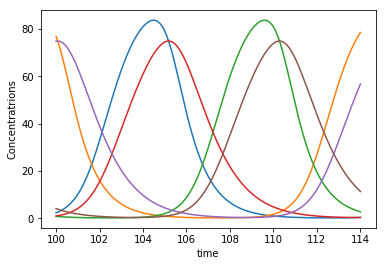

In [6]:
def plot_time_series(num_IC,t_span,data): #function to plot difference in training, cross validation and test data
    for i in np.arange(0,num_IC):
        fig = plt.plot(t_span,np.transpose(data[:,:,i]))
        plt.xlabel('time')
        plt.ylabel('Concentratrions')
        return fig

fig_train = plot_time_series(num_train,seen_span,training_data)


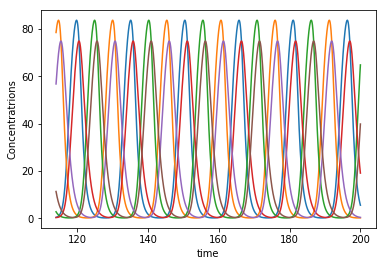

In [7]:
fig_cv = plot_time_series(num_train,unseen_span,cv_data)

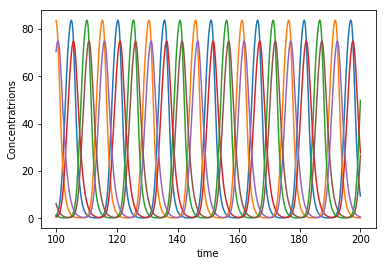

In [8]:
fig_test = plot_time_series(num_test,test_span,test_data)

### Koopman operator matrix representation

In [9]:
import DMD_algorithms #importing DMD algorithms module

DMD = getattr(DMD_algorithms, DMD_type) #calling specific DMD algorithm
K = DMD(training_data,poly_type,poly_order) # K approximation using one step estimation
print(K.shape)

(19, 19)


### Predictions

In [10]:
import Prediction  #importing one step and N step predictor modules
prediction = getattr(Prediction, step)  #calling specific predictor

import Observables #importing observables module
transformation = getattr(Observables, poly_type) #function to make the desired observable

Y_train_est, training_error = prediction(K, transformation(training_data,poly_order)) #indicator of minimization using inversion
Y_cv_est, cv_error = prediction(K, transformation(cv_data,poly_order)) #indicator of error on future of trajectories used to train
Y_test_est, test_error = prediction(K, transformation(test_data,poly_order)) #indicator of prediction on unseen initial conditions

# print(Y_train_est)
# print(Y_cv_est)
# print(Y_test_est)
print("{0:0f}%".format(training_error *100), "{0:0f}%".format(cv_error *100), "{0:0f}%".format(test_error *100))


1.154044% 19.838726% 19.810710%


### PE conditions (valid for only 1 training trajectory)